# Convolutional Autoencoder for embedding

## Overview
* [Introduction](#intro)
* [Classification of MNIST-fashion](#Classsification)
* [Autoencoder using MNIST-fashion](#Autoencoder)
* [Comparing embeddings](#Embeddings)
    - T-SNE
    - K nearest neighbour
* [Conclusion](#Conclusion)

### Introduction <a class="anchor" id="intro">


## Package import and downloading data

In [1]:
import numpy as np 
import pandas as pd

from sklearn.manifold import TSNE

import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from keras.utils.np_utils import to_categorical
from keras.datasets import fashion_mnist

from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

#from numba import cuda

import tensorflow as tf

Using TensorFlow backend.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [3]:
## Download images
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train_dummy = to_categorical(y_train)
y_test_dummy = to_categorical(y_test)

label_dict = {0: 'T-shirt/top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot'}

## Quick visualization

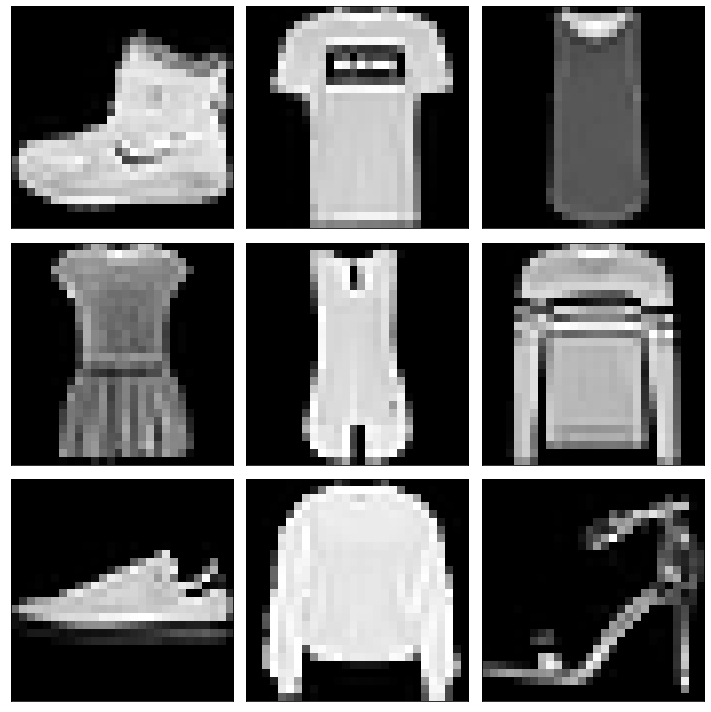

In [4]:
## Display some examples
fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize=(10,10))
cnt = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(x_train[cnt,:,:], cmap='gray')
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
        
        cnt = cnt + 1
fig.tight_layout()

## Classification of MNIST-fashion <a class='anchor' id='Classification'>

In [5]:
## Embedding using supervised learning
def build_model(lr, l2_reg):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))           
              
    model.add(Flatten())
    model.add(Dense(units=4048, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=4048, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(units=1000, activation='relu', kernel_regularizer=l2(l2_reg)))
              
    model.add(Dense(units=10, activation='softmax'))
    
    model.compile(optimizer=Adam(lr=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model
                        
    

In [5]:
## Building the model
first_model = build_model(lr=0.001, l2_reg=0.01)
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0

In [6]:
## Setup model checkpoint and training.
checkpoint_path = 'output/training/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

mcp = ModelCheckpoint(checkpoint_path, 
                      monitor='val_accuracy', 
                      mode='max', 
                      save_best_only=True,
                      save_weights_only=True)

history = first_model.fit(x_train.reshape(x_train.shape[0], 28, 28,1), 
                          y_train_dummy,
                          epochs=100,
                          validation_split=0.2,
                          batch_size=256,
                          verbose=2,
                          callbacks=[mcp]
                          )

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 - 16s - loss: 13.6764 - accuracy: 0.5921 - val_loss: 5.3193 - val_accuracy: 0.7874
Epoch 2/100
48000/48000 - 10s - loss: 3.5878 - accuracy: 0.8278 - val_loss: 2.4115 - val_accuracy: 0.8531
Epoch 3/100
48000/48000 - 10s - loss: 1.7682 - accuracy: 0.8756 - val_loss: 1.4363 - val_accuracy: 0.8338
Epoch 4/100
48000/48000 - 10s - loss: 1.0139 - accuracy: 0.8948 - val_loss: 0.8209 - val_accuracy: 0.8916
Epoch 5/100
48000/48000 - 10s - loss: 0.6539 - accuracy: 0.9071 - val_loss: 0.5703 - val_accuracy: 0.9023
Epoch 6/100
48000/48000 - 10s - loss: 0.4586 - accuracy: 0.9174 - val_loss: 0.4593 - val_accuracy: 0.9017
Epoch 7/100
48000/48000 - 11s - loss: 0.3574 - accuracy: 0.9220 - val_loss: 0.3547 - val_accuracy: 0.9133
Epoch 8/100
48000/48000 - 11s - loss: 0.2842 - accuracy: 0.9306 - val_loss: 0.3265 - val_accuracy: 0.9136
Epoch 9/100
48000/48000 - 10s - loss: 0.2442 - accuracy: 0.9352 - val_loss: 0.3232 - val_accuracy: 0.

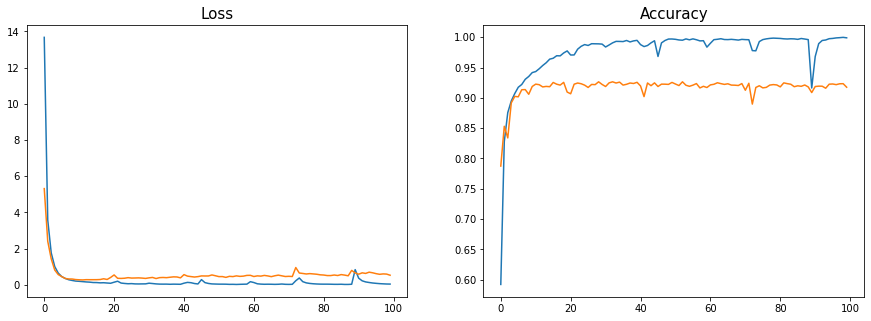

In [7]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_title('Loss', fontsize=15)

ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_title('Accuracy', fontsize=15);

In [11]:
first_model.load_weights('output/training/cp.ckpt')
first_model.save('output/trainedModel/CNN_model.h5')

In [5]:
first_model = load_model('output/trainedModel/CNN_model.h5')

new_model = Sequential()

for layer in first_model.layers[:-4]:
    new_model.add(layer)

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0

In [6]:
model_output = new_model.predict(x_train.reshape(x_train.shape[0], 28, 28,1), batch_size=256)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(model_output)
print('TSNE Done!')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 21.257s...
[t-SNE] Computed neighbors for 60000 samples in 317.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for

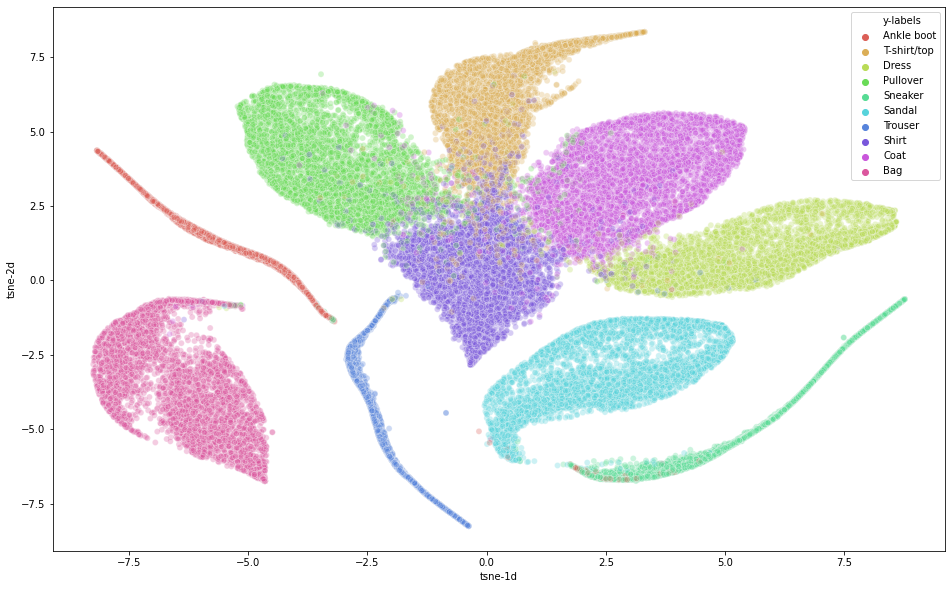

In [8]:
df = pd.DataFrame()

df['tsne-1d'] = tsne_results[:,0]
df['tsne-2d'] = tsne_results[:,1]

df['y-labels'] = [label_dict[x] for x in y_train]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-1d", y="tsne-2d",
    hue="y-labels",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

## Autoencoder using MNIST-fashion <a class='anchor' id='Autoencoder'>

In [35]:
def build_model(lr):
    input_img = Input((28,28,1))

    ## Encoding
    encoding_conv_1 = Conv2D(filters=32, 
                             kernel_size=(3,3), 
                             padding='same', 
                             activation='relu')(input_img)
    
    encoding_batchnorm_1 = BatchNormalization()(encoding_conv_1)
    
    encoding_maxpool_1 = MaxPooling2D(pool_size=(2,2))(encoding_batchnorm_1)

    encoding_conv_2 = Conv2D(filters=64, 
                             kernel_size=(3,3), 
                             padding='same', 
                             activation='relu')(encoding_maxpool_1)
    
    encoding_batchnorm_2 = BatchNormalization()(encoding_conv_2)
    
    encoding_maxpool_2 = MaxPooling2D(pool_size=(2,2))(encoding_batchnorm_2)

    encoding_conv_3 = Conv2D(filters=128, 
                             kernel_size=(3,3), 
                             padding='same',
                             activation='relu')(encoding_maxpool_2)
    
    encoding_batchnorm_3 = BatchNormalization()(encoding_conv_3)
    
    encoding_maxpool_3 = MaxPooling2D(pool_size=(2,2), padding='same')(encoding_batchnorm_3)

    encoding_conv_4 = Conv2D(filters=256, 
                             kernel_size=(3,3),
                             padding='same', 
                             activation='relu')(encoding_maxpool_3)
    
    encoding_conv_41 = Conv2D(filters=256, 
                             kernel_size=(3,3),
                             padding='same', 
                             activation='relu')(encoding_conv_4)
    
    encoding_batchnorm_4 = BatchNormalization()(encoding_conv_41)
    
    encoding_maxpool_4 = MaxPooling2D(pool_size=(4,4))(encoding_batchnorm_4)

    ## Decoding 
    decoding_conv_1 = Conv2D(filters=256,
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(encoding_maxpool_4)
    
    decoding_conv_11 = Conv2D(filters=256,
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(decoding_conv_1)
    
    deconding_batchnorm_1 = BatchNormalization()(decoding_conv_11)
    
    decoding_upscale_1 = UpSampling2D(size=(4,4))(deconding_batchnorm_1)

    decoding_conv_2 = Conv2D(filters=128,
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(decoding_upscale_1)
    
    deconding_batchnorm_2 = BatchNormalization()(decoding_conv_2)
    
    decoding_upscale_2 = UpSampling2D(size=(2,2))(deconding_batchnorm_2)

    decoding_conv_3 = Conv2D(filters=64, 
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu')(decoding_upscale_2)
    
    deconding_batchnorm_3 = BatchNormalization()(decoding_conv_3)
    
    decoding_upscale_3 = UpSampling2D(size=(2,2))(deconding_batchnorm_3)

    decoding_conv_4 = Conv2D(filters=32,
                             kernel_size=(3,3),
                             activation='relu',)(decoding_upscale_3)
    
    deconding_batchnorm_4 = BatchNormalization()(decoding_conv_4)
    
    decoding_upscale_4 = UpSampling2D(size=(2,2))(deconding_batchnorm_4)

    ## output 
    output_img = Conv2D(filters=1, 
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        padding='same')(decoding_upscale_4)

    model = Model(input_img, output_img)

    model.compile(optimizer='adam',
                  loss='mean_absolute_error')

    return model
    
cae_model = build_model(0.1)

cae_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_72 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_73 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 7, 7, 64)          0   

In [36]:
cae_model = build_model(0.01)
cae_history = cae_model.fit((x_train/255).reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1),
                            (x_train/255).reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1),
                            epochs=100,
                            validation_split=0.2,
                            shuffle=True,
                            batch_size=128,
                            verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 - 9s - loss: 0.3569 - val_loss: 0.2928
Epoch 2/100
48000/48000 - 7s - loss: 0.3165 - val_loss: 0.2902
Epoch 3/100
48000/48000 - 7s - loss: 0.2946 - val_loss: 0.2929
Epoch 4/100
48000/48000 - 7s - loss: 0.2757 - val_loss: 0.2728
Epoch 5/100
48000/48000 - 7s - loss: 0.2583 - val_loss: 0.2546
Epoch 6/100
48000/48000 - 7s - loss: 0.2426 - val_loss: 0.2381
Epoch 7/100
48000/48000 - 7s - loss: 0.2281 - val_loss: 0.2242
Epoch 8/100
48000/48000 - 7s - loss: 0.2157 - val_loss: 0.2122
Epoch 9/100
48000/48000 - 8s - loss: 0.2052 - val_loss: 0.2020
Epoch 10/100
48000/48000 - 7s - loss: 0.1965 - val_loss: 0.1935
Epoch 11/100
48000/48000 - 7s - loss: 0.1891 - val_loss: 0.1865
Epoch 12/100
48000/48000 - 7s - loss: 0.1827 - val_loss: 0.1800
Epoch 13/100
48000/48000 - 7s - loss: 0.1770 - val_loss: 0.1747
Epoch 14/100
48000/48000 - 7s - loss: 0.1723 - val_loss: 0.1705
Epoch 15/100
48000/48000 - 7s - loss: 0.1679 - val_loss: 0.1658

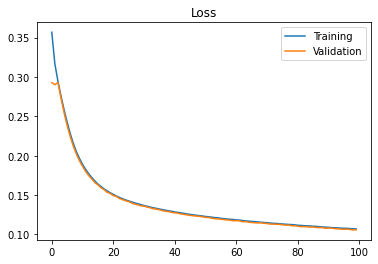

In [37]:
plt.plot(cae_history.history['loss'], label='Training')
plt.plot(cae_history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss')
plt.show()

In [38]:
output = cae_model.predict((x_train/255).reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1), batch_size=128)

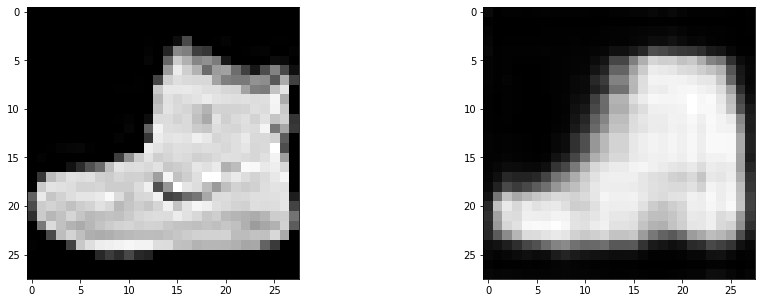

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].imshow(x_train[0]/255, cmap='gray')
ax[1].imshow(output[0,:,:,0], cmap='gray')

In [12]:
cae_model.save('output/trainedModel/CAE_model.h5')

In [40]:
#cae_model = load_model('output/trainedModel/CAE_model.h5')

new_model = Sequential()

for layer in cae_model.layers[:-13]:
    new_model.add(layer)

new_model.add(Flatten())
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_80 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_81 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 7, 7, 128)        

In [41]:
model_output = new_model.predict((x_train/255).reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1), batch_size=128)

In [42]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(model_output)
print('TSNE Done!')

TSNE Done!


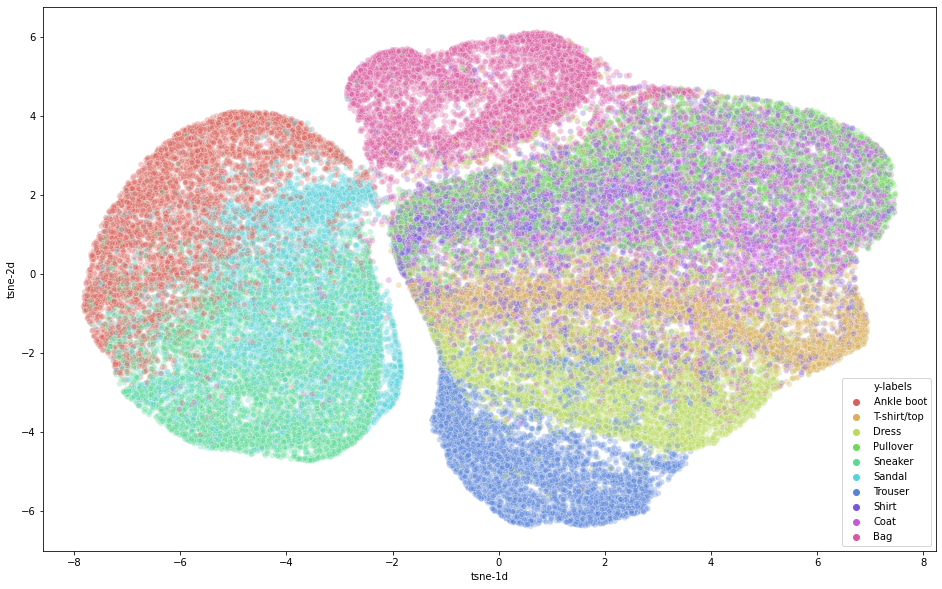

In [43]:
df = pd.DataFrame()

df['tsne-1d'] = tsne_results[:,0]
df['tsne-2d'] = tsne_results[:,1]

df['y-labels'] = [label_dict[x] for x in y_train]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-1d", y="tsne-2d",
    hue="y-labels",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

## Comparing embeddings <a class='anchor' id='Embeddings'>

### T-SNE

### K Nearest Neighbours

## Conclusion <a class='anchor' id='Conclusion'>